<a href="https://colab.research.google.com/github/pavanbaloju/agrivision-semantic-segmentation/blob/main/binary_unet_exception_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !tar -xf drive/My\ Drive/Agriculture-Vision.tar

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from tensorflow import keras

Using TensorFlow backend.


In [ ]:
img_size = (512,512)
num_classes = 1
batch_size = 8

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input((512,512,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
train_files = "Agriculture-Vision/train/images/nir/"
valid_files = "Agriculture-Vision/val/images/nir/"

partition =dict()
partition["train"] = sorted(os.listdir(train_files))[:2048]
partition["valid"] = sorted(os.listdir(valid_files))[:1024]

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, ids, path, batch_size = 32, image_size=512, ):
    self.ids = ids
    self.path = path
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()
  
  def on_epoch_end(self):
    pass
  
  def __load__(self, idname):
    rgb_path = os.path.join(self.path, "images", "rgb",idname)
    # nir_path = os.path.join(self.path, "images", "nir", idname)
    rgb_img = cv2.imread(rgb_path, 1)
   # rgb_image = np.array(r, dtype = float)
    # nir_image = np.array(cv2.imread(nir_path, -1), dtype = float)
    
    # image = np.where(nir_image + rgb_image == 0, 0, \
    #                  (nir_image - rgb_image)/(nir_image + rgb_image))
    
    labels_path = os.path.join(self.path, "labels")
    mask = np.zeros((self.image_size, self.image_size), dtype = np.bool)
    for lab_path in os.listdir(labels_path) :
      mask_path = os.path.join(labels_path, lab_path, idname[:-3]+"png")
      mask_temp = cv2.imread(mask_path, 0)
      mask = np.maximum(mask, mask_temp)
    
    image = rgb_img/255.0
    mask = mask/255.0
    return image, mask
  
  def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        #image = np.expand_dims(image, axis = -1)
        mask  = np.expand_dims(mask, axis = -1)
        return image, mask
    
  def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


In [ ]:
ids = partition["train"]
path = "Agriculture-Vision/train"
train_gen = DataGenerator(ids, path, batch_size = 8, image_size=512,)

In [ ]:
ids2 = partition["valid"]
path2 = "Agriculture-Vision/val"
valid_gen = DataGenerator(ids2, path2, batch_size = 8, image_size=512,)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics="accuracy")
from keras.models import load_model
model.load_weights('model.h5')
# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=valid_gen, batch_size= 8, verbose = 1 )

Epoch 1/15
256/256 [==============================] - 266s 1s/step - loss: 0.2387 - accuracy: 0.9017 - val_loss: 0.5958 - val_accuracy: 0.7015
Epoch 2/15
256/256 [==============================] - 267s 1s/step - loss: 0.2193 - accuracy: 0.9075 - val_loss: 0.8700 - val_accuracy: 0.7460
Epoch 3/15
256/256 [==============================] - 264s 1s/step - loss: 0.2181 - accuracy: 0.9105 - val_loss: 0.6759 - val_accuracy: 0.8099
Epoch 4/15
256/256 [==============================] - 266s 1s/step - loss: 0.2052 - accuracy: 0.9153 - val_loss: 0.5197 - val_accuracy: 0.7782
Epoch 5/15
256/256 [==============================] - 262s 1s/step - loss: 0.2027 - accuracy: 0.9164 - val_loss: 0.6465 - val_accuracy: 0.7886
Epoch 6/15
256/256 [==============================] - 265s 1s/step - loss: 0.2033 - accuracy: 0.9159 - val_loss: 0.7441 - val_accuracy: 0.7692
Epoch 7/15
256/256 [==============================] - 265s 1s/step - loss: 0.2206 - accuracy: 0.9087 - val_loss: 0.6436 - val_accuracy: 0.8082

KeyboardInterrupt: ignored

In [ ]:
model.save_weights("model.h5")

In [ ]:
 Xv ,Yv = train_gen.__getitem__(35)
Xv.shape

(8, 512, 512, 3)

In [ ]:
preds = model.predict(Xv)
preds.shape

(8, 512, 512, 1)

In [ ]:
preds = (preds > 0.05).astype(int)

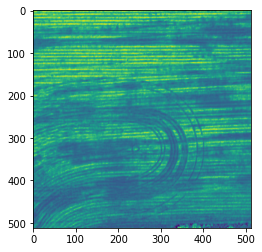

In [ ]:
index = np.random.randint(8)
import matplotlib.pyplot as plt
plt.imshow(Xv[index][:,:,0])

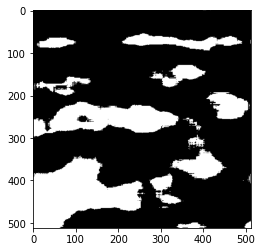

In [ ]:
plt.imshow(preds[index][:,:,0]*255, cmap ="gray")

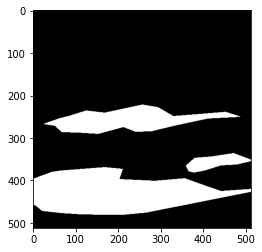

In [ ]:
plt.imshow(Yv[index][:,:,0], cmap = "gray")

In [ ]:
results = model.evaluate(valid_gen)

128/128 [==============================] - 33s 257ms/step - loss: 0.8971 - accuracy: 0.7921
